# Class definition


In [1]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""

    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in x-direction [m]
            lz .... total length of domain in x-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv

        # Calculate the control volume length
        dx = lx/float(ncv)

        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])

        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] +
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])

        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)

        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)

        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def xf(self):
        """Face location array"""
        return self._xf

    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP

    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]

    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]

    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]

    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]

    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao

    @property
    def vol(self):
        """Cell volume array"""
        return self._vol



In [2]:
import numpy as np

class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """

    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)

    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)

    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP

    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE

    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP

    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW

    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE

    @property
    def rP(self):
        """Cell residual"""
        return self._rP



In [3]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

class DirichletBc:
    """Class defining a Dirichlet boundary condition"""

    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        return self._value

    def coeff(self):
        """Return the linearization coefficient"""
        return 0

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

class NeumannBc:
    """Class defining a Neumann boundary condition"""

    def __init__(self, phi, grid, gradient, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._gradient = gradient
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

    def coeff(self):
        """Return the linearization coefficient"""
        return 1

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")
class RobinBc:
    """Class defining a Robin boundary condition"""
    
    def __init__(self, phi, grid, h, k, Tamb, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            h........... convection coefficient
            k........... thermal conductivity 
            Tamb........ ambient temperature
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._h = h
        self._k = k
        self._Tamb = Tamb
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return (self._phi[1] + ((self._h/self._k)*self._grid.dx_WP[0]* self._Tamb))/(1+((self._h/self._k)*self._grid.dx_WP[0]))
        elif self._loc is BoundaryLocation.EAST:
            return (self._phi[-2] + ((self._h/self._k)*self._grid.dx_PE[-1]* self._Tamb))/(1+((self._h/self._k)*self._grid.dx_PE[-1]))
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        if self._loc is BoundaryLocation.WEST:
            return (1/(1+((self._h/self._k)*self._grid.dx_WP[0])))
        elif self._loc is BoundaryLocation.EAST:
            return (1/(1+((self._h/self._k)*self._grid.dx_PE[-1])))
      
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = (self._phi[1] + ((self._h/self._k)*self._grid.dx_WP[0]* self._Tamb))/(1+((self._h/self._k)*self._grid.dx_WP[0]))
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = (self._phi[-2] + ((self._h/self._k)*self._grid.dx_PE[-1]* self._Tamb))/(1+((self._h/self._k)*self._grid.dx_PE[-1]))
        else:
            raise ValueError("Unknown boundary location")


In [19]:
class DiffusionModel:
    """Class defining a diffusion model"""

    def __init__(self, grid, w, phi, phiold, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._w = w
        self._phiold = phiold
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._w*self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._w*self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE

        # Calculate the linearization coefficients
        coeffW = - self._w*self._gamma*self._grid.Aw/self._grid.dx_WP  
        coeffE = - self._w*self._gamma*self._grid.Ae/self._grid.dx_PE  
        coeffP = (- coeffW - coeffE )   

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        CN = (1 -self._w)* ((self._gamma*self._grid.Aw*(self._phiold[1:-1]-self._phiold[0:-2])/self._grid.dx_WP) - (self._gamma*self._grid.Ae*(self._phiold[2:]-self._phiold[1:-1])/self._grid.dx_PE))
        flux = (flux_e - flux_w) + CN

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)

        # Return the modified coefficient array
        return coeffs


In [20]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)



In [21]:
class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        transientterm = self._rho * self._cp * self._grid.vol * ((self._T[1:-1]-self._Told[1:-1])/self._dt)
        
        # Calculate the linearization coefficient
        coeffP = (self._rho * self._cp * self._grid.vol)/self._dt
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(transientterm)
        return coeffs
    

## Grid Independence test with different number of control volumes
### 5 control volumes

In [22]:
""" Case 1 : Specification and computation with 5 control volumes"""
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 120
converged = 1e-5

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
w = (1/2)
diffusion = DiffusionModel(grid, w, T, Told, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T5 = T_solns[-1]  
xP5 = grid.xP
diff_5 = T_final-T5
print('Difference between Analytical & Numerical solution at final timestep',diff_5)
e_5 = sum(diff_5) / len(diff_5)
print('Absolute average error = ',abs(e_5))

Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 11.76928738102262; Avg. Resid. = 10.399272829619466
Iteration = 1; Max. Resid. = 5.5067062021407764e-14; Avg. Resid. = 3.019806626980426e-14
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 11.026222364990799; Avg. Resid. = 9.750962187046571
Iteration = 1; Max. Resid. = 1.5987211554602254e-14; Avg. Resid. = 1.1013412404281553e-14
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 10.325859449351638; Avg. Resid. = 9.140008624107283
Iteration = 1; Max. Resid. = 3.019806626980426e-14; Avg. Resid. = 2.2026824808563106e-14
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 9.67441496443971; Avg. Resid. = 8.56747857059604
Iteration = 1; Max. Resid. = 2.4868995751603507e-14; Avg. Resid. = 1.6342482922482303e-14
Timestep = 4; Time = 0.8925149999999998
Iteration = 0; Max. Resid. = 9.067829696711021; Avg. Resid. = 8.030443858748713
Iteration = 1; Max. Resid. = 2.1316282072803006e-14

### 10 control volumes

In [23]:
""" Case 1 : Specification and computation with 10 control volumes"""
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 10
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 120
converged = 1e-5

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
w = (1/2)
diffusion = DiffusionModel(grid, w, T, Told, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T10 = T_solns[-1]  
xP10 = grid.xP
diff_10 = T_final-T10
print('Difference between Analytical & Numerical solution at final timestep',diff_10)
e_10 = sum(diff_10) / len(diff_10)
print('Absolute average error = ',abs(e_10))

Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 5.911956219801765; Avg. Resid. = 5.21311491390288
Iteration = 1; Max. Resid. = 4.529709940470639e-14; Avg. Resid. = 2.495781359357352e-14
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 5.539715895045133; Avg. Resid. = 4.885868539859227
Iteration = 1; Max. Resid. = 1.0036416142611415e-13; Avg. Resid. = 3.9568348597640577e-14
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 5.19036754482542; Avg. Resid. = 4.5785827541041995
Iteration = 1; Max. Resid. = 6.306066779870889e-14; Avg. Resid. = 2.842170943040401e-14
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 4.8634379586914624; Avg. Resid. = 4.29079822511201
Iteration = 1; Max. Resid. = 6.217248937900877e-14; Avg. Resid. = 2.4602542225693468e-14
Timestep = 4; Time = 0.8925149999999998
Iteration = 0; Max. Resid. = 4.557671233044402; Avg. Resid. = 4.020947924652898
Iteration = 1; Max. Resid. = 4.529709940470639e-14; Avg.

### 20 control volumes

In [24]:
""" Case 1 : Specification and computation with 20 control volumes"""
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 200
converged = 1e-5

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
w = (1/2)
diffusion = DiffusionModel(grid, w, T, Told, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T20 = T_solns[-1]  
xP20 = grid.xP
diff_20 = T_final-T20
print('Difference between Analytical & Numerical solution at final timestep',diff_20)
e_20 = sum(diff_20) / len(diff_20)
print('Absolute average error  = ',abs(e_20))

Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 2.9593993706063766; Avg. Resid. = 2.6083070032713302
Iteration = 1; Max. Resid. = 1.687538997430238e-13; Avg. Resid. = 7.879252805764736e-14
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 2.773148239593865; Avg. Resid. = 2.444202070406243
Iteration = 1; Max. Resid. = 1.7852386235972517e-13; Avg. Resid. = 6.044054146059352e-14
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 2.598592715442009; Avg. Resid. = 2.2903866339335446
Iteration = 1; Max. Resid. = 1.6653345369377348e-13; Avg. Resid. = 6.664668816824814e-14
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 2.4350411843300885; Avg. Resid. = 2.1462661012577446
Iteration = 1; Max. Resid. = 7.194245199571014e-14; Avg. Resid. = 2.848832281188152e-14
Timestep = 4; Time = 0.8925149999999998
Iteration = 0; Max. Resid. = 2.2818119143171596; Avg. Resid. = 2.0112008661482648
Iteration = 1; Max. Resid. = 1.1390888232654106e-

### Plot for Grid convergence test

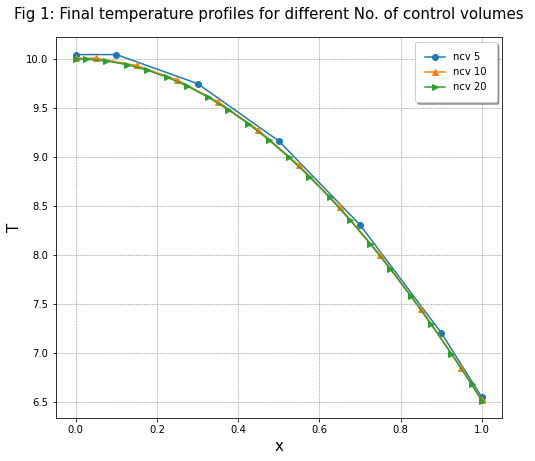

In [10]:
""" Plot for testing Grid convergence """
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize =(8,7))

plt.plot(xP5, T5 , marker = "o", label = "ncv 5")
plt.plot(xP10, T10, marker = "^", label = "ncv 10")
plt.plot(xP20, T20, marker = ">", label = "ncv 20")

plt.xlabel('x',fontsize = 15)
plt.ylabel('T',fontsize = 15)
plt.suptitle('Fig 1: Final temperature profiles for different No. of control volumes ', fontsize=15,y=0.94)
plt.grid(True)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

### Comments on the grid convergence test :
Starting from 5 control volumes, we went upto to taking 20 control volumes in half of the plane wall (From x=0 to x=L) for discretion of the field equation. The numerical solution for all 3 cases i.e. 5, 10, 20 control volumes show very close temperature profiles as shown in the graph above. But beyond 5 control volumes, the numerical solution curves overlap, so considering the graph only, we can say that 10 control volumes are sufficient for solving this problem. 

To dig deeper into the accuracy of solutions for each case, we also calculated the difference between the numerical solution and analytical solution at each internal control volume. The one-term fourier analytical solution of the problem is given by :
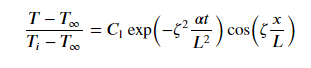
It was observed that, for the first case (ncv=5), the average error in the temperature values at the final timestep is  0.061 and as we increase the number of control volumes to 10 and 20 the average error becomes 0.0104 and 0.0031 respectively. So we can say that, beyond 20 control volumes the Analytical & Numerical solutions at the final timestep match upto 2 digits of accuracy. 

Thus, judging from the graph and comparing with the analytical solution, it is safe to conclude that 20 control volumes are sufficient for discretizing the problem using the Crank Nicholson Scheme. 


## Temporal discretization with different time step sizes

##  2 timesteps

In [25]:
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 2
dt = 1.40485
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 120
converged = 1e-5

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
w = (1/2)
diffusion = DiffusionModel(grid, w, T, Told, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T_2 = T_solns[-1]
dt2 = dt
print('Difference between Analytical & Numerical solution at final timestep ',T_final- T_2)
ei_2 = T_final[1:-1]- T_2[1:-1]
e_2 = sum(ei_2) / len(ei_2) # Where len(ei_2) = ncv
print('Absolute average error = ',abs(e_2))

Timestep = 0; Time = 1.85835
Iteration = 0; Max. Resid. = 2.9593993706063766; Avg. Resid. = 2.6083070032713302
Iteration = 1; Max. Resid. = 2.502442697505103e-13; Avg. Resid. = 8.786305016883489e-14
Timestep = 1; Time = 3.2632
Iteration = 0; Max. Resid. = 0.9350057637671225; Avg. Resid. = 0.824214252150145
Iteration = 1; Max. Resid. = 5.917488721252084e-14; Avg. Resid. = 2.955968803064479e-14
[7.98605581 7.98605581 7.97128015 7.94175612 7.89753826 7.83870825
 7.76537477 7.67767328 7.57576578 7.45984051 7.33011158 7.1868186
 7.03022623 6.86062366 6.67832409 6.48366417 6.27700333 6.05872314
 5.82922658 5.58893732 5.33829889 5.20809648]
Analytical Final Temperature field = [9.9996306  9.99731791 9.97882282 9.94186686 9.8865184  9.81287983
 9.72108738 9.61131088 9.4837534  9.33865093 9.17627191 8.99691674
 8.80091723 8.58863599 8.36046572 8.11682855 7.8581752  7.5849842
 7.29776093 6.99703677 6.68336806 6.52185993]
Difference between Analytical & Numerical solution at final timestep  [2.01

##  4 timesteps

In [26]:
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 4
dt = 0.702425
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 120
converged = 1e-5

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
w = (1/2)
diffusion = DiffusionModel(grid, w, T, Told, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T_4 = T_solns[-1]
dt4 = dt
print('Difference between Analytical & Numerical solution at final timestep ',T_final- T_4)
ei_4 = T_final[1:-1]- T_4[1:-1]
e_4 = sum(ei_4) / len(ei_4) # Where len(ei_4) = ncv
print('Absolute average error = ',abs(e_4))

Timestep = 0; Time = 1.1559249999999999
Iteration = 0; Max. Resid. = 2.9593993706063766; Avg. Resid. = 2.6083070032713302
Iteration = 1; Max. Resid. = 1.5898393712632242e-13; Avg. Resid. = 6.897815651996097e-14
Timestep = 1; Time = 1.8583499999999997
Iteration = 0; Max. Resid. = 1.7383630408723145; Avg. Resid. = 1.5322694018531975
Iteration = 1; Max. Resid. = 8.126832540256146e-14; Avg. Resid. = 3.842481888227667e-14
Timestep = 2; Time = 2.5607749999999996
Iteration = 0; Max. Resid. = 1.0212190552354625; Avg. Resid. = 0.9000871874611281
Iteration = 1; Max. Resid. = 4.951594689828198e-14; Avg. Resid. = 2.2598589666245063e-14
Timestep = 3; Time = 3.2631999999999994
Iteration = 0; Max. Resid. = 0.5999142869804074; Avg. Resid. = 0.528773149876491
Iteration = 1; Max. Resid. = 4.2299497238218464e-14; Avg. Resid. = 1.4999113062685864e-14
[9.52484544 9.52484544 9.50722604 9.4720198  9.41929175 9.34913933
 9.26169211 9.15711165 9.03559107 8.89735477 8.74265796 8.57178616
 8.38505465 8.18280784 

##  8 Timesteps


In [27]:
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 8
dt = 0.351213
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 120
converged = 1e-5

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
w = (1/2)
diffusion = DiffusionModel(grid, w, T, Told, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T_8 = T_solns[-1]
dt8 = dt
print('Difference between Analytical & Numerical solution at final timestep ',T_final- T_8)
ei_8 = T_final[1:-1]- T_8[1:-1]
e_8 = sum(ei_8) / len(ei_8) # Where len(ei_8) = ncv
print('Absolute average error = ',abs(e_8))

Timestep = 0; Time = 0.804713
Iteration = 0; Max. Resid. = 2.9593993706063766; Avg. Resid. = 2.6083070032713302
Iteration = 1; Max. Resid. = 1.2745360322696797e-13; Avg. Resid. = 5.1958437552457326e-14
Timestep = 1; Time = 1.155926
Iteration = 0; Max. Resid. = 2.278643448681805; Avg. Resid. = 2.0084332108208898
Iteration = 1; Max. Resid. = 1.2168044349891716e-13; Avg. Resid. = 5.2580162446247416e-14
Timestep = 2; Time = 1.507139
Iteration = 0; Max. Resid. = 1.754528693676178; Avg. Resid. = 1.5464651126763498
Iteration = 1; Max. Resid. = 7.016609515630989e-14; Avg. Resid. = 2.918776331739536e-14
Timestep = 3; Time = 1.858352
Iteration = 0; Max. Resid. = 1.3510237520928567; Avg. Resid. = 1.190792885836413
Iteration = 1; Max. Resid. = 5.595524044110789e-14; Avg. Resid. = 2.7844393457598927e-14
Timestep = 4; Time = 2.209565
Iteration = 0; Max. Resid. = 1.0402543632082482; Avg. Resid. = 0.9168942821438751
Iteration = 1; Max. Resid. = 4.1300296516055823e-14; Avg. Resid. = 1.974531649295841e-

##  16 Timesteps

In [28]:
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 16
dt = 0.175606
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 120
converged = 1e-5

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
w = (1/2)
diffusion = DiffusionModel(grid, w, T, Told, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final)
T_16 = T_solns[-1]
dt16 = dt
print('Difference between Analytical & Numerical solution at final timestep ',T_final- T_16)
ei_16 = T_final[1:-1]- T_16[1:-1]
e_16 = sum(ei_16) / len(ei_16) # Where len(ei_16) = ncv
print('Absolute average error = ',abs(e_16))

Timestep = 0; Time = 0.629106
Iteration = 0; Max. Resid. = 2.9593993706063766; Avg. Resid. = 2.6083070032713302
Iteration = 1; Max. Resid. = 1.8385293287792592e-13; Avg. Resid. = 6.132871988029364e-14
Timestep = 1; Time = 0.8047120000000001
Iteration = 0; Max. Resid. = 2.598250230182941; Avg. Resid. = 2.290087362108104
Iteration = 1; Max. Resid. = 1.2101430968414206e-13; Avg. Resid. = 3.8813396940895475e-14
Timestep = 2; Time = 0.9803180000000001
Iteration = 0; Max. Resid. = 2.281163230861409; Avg. Resid. = 2.0106433917748845
Iteration = 1; Max. Resid. = 9.592326932761353e-14; Avg. Resid. = 4.7029047323121634e-14
Timestep = 3; Time = 1.1559240000000002
Iteration = 0; Max. Resid. = 2.0028393414256125; Avg. Resid. = 1.7653231352927243
Iteration = 1; Max. Resid. = 1.163513729807164e-13; Avg. Resid. = 5.5788706987414116e-14
Timestep = 4; Time = 1.33153
Iteration = 0; Max. Resid. = 1.758462209775899; Avg. Resid. = 1.5499149375237649
Iteration = 1; Max. Resid. = 1.1679546219056647e-13; Avg. 

##  32 Timesteps

In [29]:
import numpy as np
from numpy.linalg import norm
import math

# Define the grid
lx = 1.0
ly = 1.0
lz = 1.0
ncv = 20
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 32
dt = 0.087803
time = 0.4535

# Set the maximum number of iterations and convergence criterion
maxIter = 120
converged = 1e-5

# Define thermophysical properties
rho = 1
cp = 1
k = 1

# Define convection parameters
ho = 1
To = 0        # Ambient temperature 

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
C1 = 1.1191
zeta = 0.8603
ti = 0.4535   # Initial time
Ti = 100      # Temperature at time t=0

# Initialize field variable arrays
T = np.ones(grid.ncv+2)
for i in range(ncv+2):
    T[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time))*math.cos((zeta*grid.xP[i])/lx))) + To

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = RobinBc(T, grid, ho, k, To, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each timestep
T_solns = [np.copy(T)]

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
w = (1/2)
diffusion = DiffusionModel(grid, w, T, Told, k, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" temperature field
    Told[:] = T[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break
    
        # Solve the sparse matrix system
        dT = solve(coeffs)
    
        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
print((T_solns[-1]))    

# Analytical Solution at Final timestep
T_final_32 = np.ones(grid.ncv+2)
time_f = 3.2632
for i in range(ncv+2):
    T_final_32[i] = ((Ti-To)*((1.1191*math.exp((-zeta**2)*time_f))*math.cos((zeta*grid.xP[i])/lx))) + To
print('Analytical Final Temperature field =',T_final_32)
T_32 = T_solns[-1]
dt32 = dt
xP = grid.xP
print('Difference between Analytical & Numerical solution at final timestep ',T_final_32- T_32)
ei_32 = T_final_32[1:-1]- T_32[1:-1]
e_32 = sum(ei_32) / len(ei_32) # Where len(ei_32) = ncv
print('Absolute average error = ',abs(e_32))


Timestep = 0; Time = 0.541303
Iteration = 0; Max. Resid. = 2.9593993706063766; Avg. Resid. = 2.6083070032713302
Iteration = 1; Max. Resid. = 1.687538997430238e-13; Avg. Resid. = 7.879252805764736e-14
Timestep = 1; Time = 0.6291059999999999
Iteration = 0; Max. Resid. = 2.773148239593865; Avg. Resid. = 2.444202070406243
Iteration = 1; Max. Resid. = 1.7852386235972517e-13; Avg. Resid. = 6.044054146059352e-14
Timestep = 2; Time = 0.7169089999999999
Iteration = 0; Max. Resid. = 2.598592715442009; Avg. Resid. = 2.2903866339335446
Iteration = 1; Max. Resid. = 1.6653345369377348e-13; Avg. Resid. = 6.664668816824814e-14
Timestep = 3; Time = 0.8047119999999999
Iteration = 0; Max. Resid. = 2.4350411843300885; Avg. Resid. = 2.1462661012577446
Iteration = 1; Max. Resid. = 7.194245199571014e-14; Avg. Resid. = 2.848832281188152e-14
Timestep = 4; Time = 0.8925149999999998
Iteration = 0; Max. Resid. = 2.2818119143171596; Avg. Resid. = 2.0112008661482648
Iteration = 1; Max. Resid. = 1.1390888232654106e-

## Plot of Final temperature profile for different number of timesteps

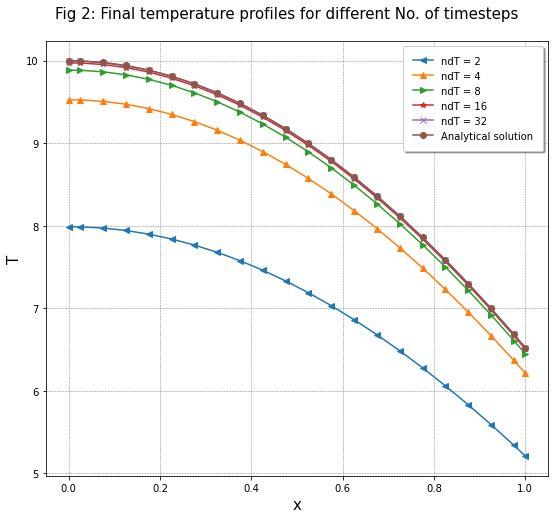

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize =(9,8))

plt.plot(xP, T_2 , marker = "<", label = "ndT = 2")
plt.plot(xP, T_4, marker = "^", label = "ndT = 4")
plt.plot(xP, T_8, marker = ">", label = "ndT = 8")
plt.plot(xP, T_16, marker = "*",label = "ndT = 16")
plt.plot(xP, T_32, marker = "x",label = "ndT = 32")
plt.plot(xP,T_final_32,marker = "o",label = "Analytical solution")

plt.xlabel('x',fontsize = 15)
plt.ylabel('T',fontsize = 15)
plt.suptitle('Fig 2: Final temperature profiles for different No. of timesteps ', fontsize=15,y=0.94)
plt.grid(True)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

## Plot of absolute average error vs timestep size

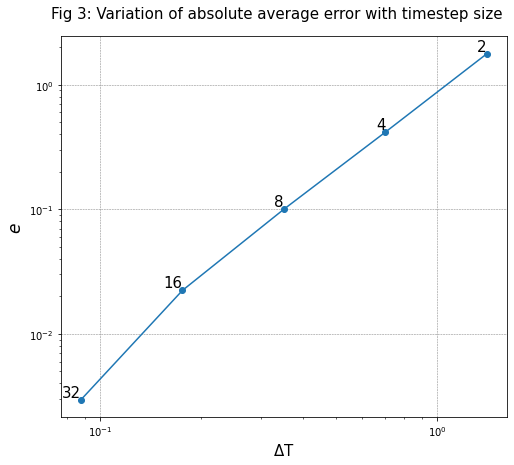

Order of Accuracy of the First order transient scheme = 2.4136187433457543


In [32]:
""" Plot for testing temporal discretization error  """
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.figure(figsize =(8,7))

errors = [abs(e_2), abs(e_4), abs(e_8), abs(e_16),abs(e_32)]
timesteps = [dt2, dt4, dt8, dt16, dt32]

plt.loglog(timesteps, errors , marker = "o")

# Function to calculate the exponential with constants a and b
def exponential(x, a, b):
    return a*np.exp(b*x)
# Fit the dummy exponential data
pars, cov = curve_fit(f=exponential, xdata=timesteps, ydata=errors, p0=[0, 0], bounds=(-np.inf, np.inf))
c = pars[1]
p = pars [-1]

plt.xlabel((r'$\Delta $T'),fontsize = 15)
plt.ylabel((r'$e$'),fontsize = 17)
plt.suptitle('Fig 3: Variation of absolute average error with timestep size', fontsize=15,y=0.94)
n = [2, 4, 8, 16, 32]

for i, txt in enumerate(n):
    plt.annotate(txt, (timesteps[i], errors[i]),fontsize=15, ha='right', va='bottom')

plt.grid(True)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()
print('Order of Accuracy of the First order transient scheme =',p)

## Comments of error variation with timestep size

In $Fig.2$ we have plotted the temperature profile at final time (3.2632 second) over half of the plane wall (from x=0 to x=L) for different number of timesteps. It is observed that, the temperature profile for 32 timesteps with $\Delta $T = 0.087803 is the closest to the Analytical solution and the temperature profile for 2 timesteps with $\Delta $T = 1.40485 is the farthest. This indicates that, more the number of timesteps we use i.e. smaller the timestep size, better will be the accuracy of the solution.

In $Fig.3$, we have plotted the absolute average error vs the time step size for first order transient scheme and fitted an exponential curve on the log-log plot to obtain the exponent $p$ in $e$ = $c(\Delta T)^{p}$ as 2.41 which rounds down to 2. Thus, our plot supports the conclusion that the Crank Nicholson Scheme is Second order accurate.

## Plot of T(0,t2) vs Number of timesteps

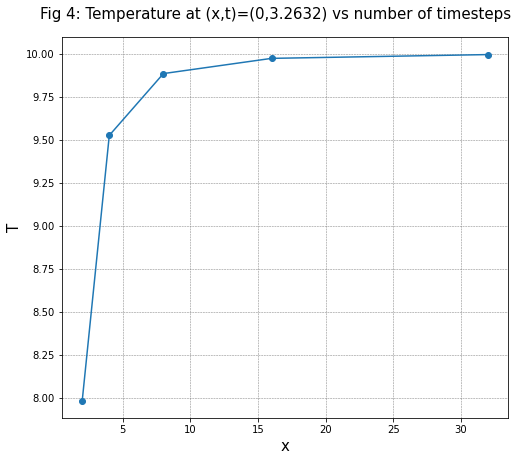

In [33]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize =(8,7))

xarray = [2,4,8,16,32]
yarray = [T_2[1],T_4[1],T_8[1],T_16[1],T_32[1] ]
plt.plot(xarray, yarray , marker = "o")


plt.xlabel('x',fontsize = 15)
plt.ylabel('T',fontsize = 15)
plt.suptitle('Fig 4: Temperature at (x,t)=(0,3.2632) vs number of timesteps ', fontsize=15,y=0.94)
plt.grid(True)
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.show()

From the Analytical solution we know that at x=0 at the final timestep i.e. $t_{2}$ = 3.2632 second, the temperature should be 10 [$^\circ$C]. When we divide the time interval into 2 timesteps only, then we obtaint T(0,$t_{2}$) = 7.98 [$^\circ$C]. Then as we increase the number of timesteps to 4,8,16 and finally 32 we get T(0,$t_{2}$) = 9.524, 9.883, 9.972 and 9.994 [$^\circ$C] respectively. Thus when the time interval is divided into 32 timesteps, the temperature at the centerline of the plane wall at the end of simulation is closest to the analytical temperature. 

# Comparison between First order implicit, Second order implicit and Crank Nicholson Scheme

For all the three schemes, we used 20 control volumes for discretization so that the variation of temporal discretization error from the three schemes become more transparent during comparison. For each scheme, we solved the problem employing 2,4,8,16 and 32 timesteps. 

  1. At final time $t_{2}$ = 3.2632 second, the Temperature T(0,$t_{2}$ ) for each scheme for each run is summarized as below:
      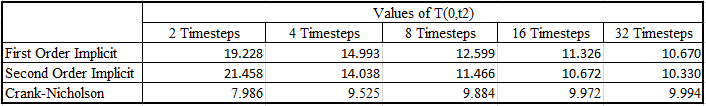
      
      For all the three schemes we observed that when we used the smallest timestep size i.e. the largest number of timesteps(32), we get the temperature at (0,$t_{2}$) closest to the analytical solution (10 $^\circ$C). Even then, for Crank Nicholson scheme we get closest accuracy to the Anlaytical Solution.
      
      
  2. For each scheme for each run the absolute average error values are tabulated as below:
  
      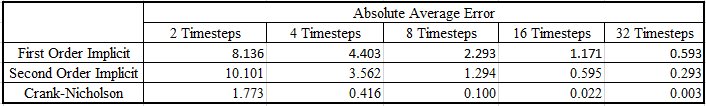
      
       From the above values it becomes clear once again that for the first order implicit scheme error decreases almost in power of 1 with increase in number of timesteps, for the second order implicit scheme error decreases approximately in power of 2 with increase in number of timesteps and for Crank Nicholson scheme the absolute avreage error decrease approximately in power of 2 with increase in number of timesteps. However, the error for Crank Nicholson scheme for every run is significantly lesser than the other two schemes and at (0,$t_{2}$) for 32 timesteps, the absolute average error for Crank Nicholson scheme is the smallest (0.003).
       
       So we can conclude that the Crank Nicholson transient discretization scheme (with w= 1/2) gives better accuracy than the first order and second order implicit scheme